# Experimenting with known location

- this playbook contains the code for the experimentation with new location

In [1]:
import os
import csv
import pandas as pd

version = "v6"
dataset_path = f"../data/processed/"

# files
filename_s = f"{version}-2_stages-full_statistical.csv"
filename_s_n = f"{version}-2_stages-full_statistical_normalized.csv"
filename_s_s = f"{version}-2_stages-full_statistical_standardized.csv"
filename_f = f"{version}-2_stages-fourier_int_XYZ.csv"
filename_f_n = f"{version}-2_stages-fourier_normalized_int_XYZ.csv"
filename_f_s = f"{version}-2_stages-fourier_standardized_XYZ.csv"


# datasets
df_statistical = pd.read_csv(f"{dataset_path}/{filename_s}")
df_statistical_normalized = pd.read_csv(f"{dataset_path}/{filename_s_n}")
df_statistical_standardized = pd.read_csv(f"{dataset_path}/{filename_s_s}")
df_spectral = pd.read_csv(f"{dataset_path}/{filename_f}")
df_spectral_normalized = pd.read_csv(f"{dataset_path}/{filename_f_n}")
df_spectral_standardized = pd.read_csv(f"{dataset_path}/{filename_f_s}")

In [5]:
from lib import device_mapping, reverse_device_mapping, rotations_mapping

# ------------------------------------------------
# choice of dataset

# df = df_statistical # 56, 67
# df = df_statistical_normalized  # 54 63
# df = df_statistical_standardized    # 66, 72
# df = df_spectral    # 74, 77
# df = df_spectral_normalized #77 78
df = df_spectral_standardized   #89, 80

# ------------------------------------------------
# choice of phone

# GooglePixel6:        03575768cc23b2df
# RedmiNote8PRO:       4aaf95a621ccf092
# SamsungGalaxyA51:    029a77f196804217
# SamsungGalaxyS6:     e08d976ac75c011e



df = df[df['device_id'].isin(reverse_device_mapping(['GooglePixel6']))]
# df = df[df['device_id'].isin(reverse_device_mapping(['RedmiNote8PRO']))]
# df = df[df['device_id'].isin(reverse_device_mapping(['GooglePixel6', 'RedmiNote8PRO']))]
# df = df[df['device_id'].isin(reverse_device_mapping(['SamsungGalaxyA51', 'SamsungGalaxyS6']))]


# choose only cases with mulitple rotation
df['rotation'] = df['location'].apply(lambda x: rotations_mapping[x])
df = df[df['rotation']]

# number of cases per device
df['location'].value_counts()


/tmp/ipykernel_114791/3483544105.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rotation'] = df['location'].apply(lambda x: rotations_mapping[x])


DormRoom7    6400
DormRoom2    6175
Name: location, dtype: int64

In [56]:
import random
rotations = list(df[df['location'] == "DormRoom7"]["name"].str[:-3].unique())
random.shuffle(rotations)
rotations

['PiXmilenkosRoomTrafficRotationsTable270_',
 'PiXmilenkosRoomTrafficRotationsTable135_',
 'PiXmilenkosRoomTrafficRotationsTable45_',
 'PiXmilenkosRoomTrafficRotationsTable315_',
 'PiXmilenkosRoomTrafficRotationsTable225_',
 'PiXmilenkosRoomTrafficRotationsTable90_',
 'PiXmilenkosRoomTrafficRotationsTable0_',
 'PiXmilenkosRoomTrafficRotationsTable180_']

In [57]:
i = 2
df[df['name'].str.contains('|'.join(rotations[:i+1]))]

,Unnamed: 0,name,location,device_id,label,intensity_1,intensity_2,intensity_3,intensity_4,intensity_5,...,Z_42,Z_43,Z_44,Z_45,Z_46,Z_47,Z_48,Z_49,Z_50,rotation
2872,2872,PiXmilenkosRoomTrafficRotationsTable135_000,DormRoom7,03575768cc23b2df,5,4.236385,0.646203,0.504932,0.400745,0.553446,...,0.303245,0.384806,0.480488,0.447453,0.293880,0.268887,0.389458,0.400556,0.329511,True
2873,2873,PiXmilenkosRoomTrafficRotationsTable135_001,DormRoom7,03575768cc23b2df,5,4.182259,0.626051,0.450506,0.402187,0.524465,...,0.306993,0.388222,0.476695,0.446801,0.294512,0.269664,0.386749,0.397101,0.322279,True
2874,2874,PiXmilenkosRoomTrafficRotationsTable135_002,DormRoom7,03575768cc23b2df,5,4.171799,0.619771,0.441972,0.402817,0.533208,...,0.301896,0.379857,0.487676,0.450772,0.296210,0.251386,0.381164,0.386525,0.304268,True
2875,2875,PiXmilenkosRoomTrafficRotationsTable135_003,DormRoom7,03575768cc23b2df,5,4.168510,0.610973,0.435277,0.395554,0.547574,...,0.308984,0.393095,0.482240,0.448990,0.308357,0.252192,0.383627,0.384714,0.277268,True
2876,2876,PiXmilenkosRoomTrafficRotationsTable135_004,DormRoom7,03575768cc23b2df,5,4.170287,0.609582,0.437075,0.392700,0.548365,...,0.303365,0.387033,0.478995,0.446760,0.309866,0.257143,0.388471,0.388656,0.272842,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23992,23992,PiXmilenkosRoomTrafficRotationsTable45_395,DormRoom7,03575768cc23b2df,6,3.109442,1.003960,0.518470,0.403195,0.479466,...,0.208207,0.150779,0.253431,0.186947,0.213635,0.147304,0.261399,0.183463,0.142561,True
23993,23993,PiXmilenkosRoomTrafficRotationsTable45_396,DormRoom7,03575768cc23b2df,6,3.108794,1.008378,0.516204,0.401831,0.484437,...,0.209175,0.154098,0.252744,0.189077,0.212143,0.144416,0.262175,0.194899,0.139791,True
23994,23994,PiXmilenkosRoomTrafficRotationsTable45_397,DormRoom7,03575768cc23b2df,6,3.109655,1.004503,0.517834,0.402842,0.478821,...,0.210117,0.155867,0.252059,0.190310,0.213370,0.145255,0.261600,0.196032,0.140756,True
23995,23995,PiXmilenkosRoomTrafficRotationsTable45_398,DormRoom7,03575768cc23b2df,6,3.111952,1.002724,0.518478,0.404394,0.485081,...,0.212891,0.161117,0.249301,0.190616,0.218064,0.145850,0.259591,0.186181,0.130912,True


In [58]:
def map_classes(x):
    if x == 5:
        return 1
    return 0
def map_back_classes(x):
    if x == 1:
        return 5
    return 6

In [70]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from lib import device_mapping
import numpy as np


results = []
for i in range(len(rotations)):
    results_len = []
    for _ in range(50):

        sample = random.sample(rotations, i+1)

        # train on random sample of len i+1 rotations from "DormRoom7", test is DormRoom2
        test = df[df['location'] == "DormRoom2"]
        train = df[df['name'].str.contains('|'.join(sample))]

        # correlation and selection
        correlation = df.iloc[:, 6:].apply(lambda x: df['label'].corr(x, method="pearson")).abs().sort_values(ascending=False)
        selection = correlation[:10].index

        y_test = test['label'].to_numpy()
        X_test = test[selection].to_numpy()
        y_train = train['label'].to_numpy()
        X_train = train[selection].to_numpy()

        # SVM
        clf = svm.SVC(decision_function_shape='ovo')
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc_svm = sum([1 for i in range(len(y_pred)) if y_pred[i] == y_test[i]])/len(y_pred)
        f1_svm = f1_score(list(map(map_classes, y_test)), list(map(map_classes, y_pred)))

        # RF
        clf = RandomForestClassifier(max_depth=3)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc_rf = sum([1 for i in range(len(y_pred)) if y_pred[i] == y_test[i]])/len(y_pred)
        f1_rf = f1_score(list(map(map_classes, y_test)), list(map(map_classes, y_pred)))

        device_name = device_mapping[test['device_id'].iloc[0]]
        location = test['location'].iloc[0]
        results_temp = [i+1, acc_svm, f1_svm, acc_rf, f1_rf]
        results_len.append(results_temp)
    res_averaged = np.average(results_len, axis=0)
    print(res_averaged)
    results.append(res_averaged)

results_all = pd.DataFrame(results, columns=['# of rotations', 'SVM_acc', 'SVM_f1', 'RF_acc', 'RF_f1'])
results_all

[1.         0.81203563 0.75022495 0.86030121 0.86131233]
[2.         0.85825749 0.83144845 0.87167611 0.87253928]
[3.         0.87898947 0.88032451 0.8609587  0.8601165 ]
[4.         0.89453603 0.90022128 0.8762332  0.87906776]
[5.         0.88357571 0.88813277 0.87737976 0.88085781]
[6.         0.89033522 0.89632542 0.87403401 0.87800759]
[7.         0.90145749 0.90787179 0.87435789 0.87831904]
[8.         0.92647773 0.9323801  0.87448097 0.87842384]


,# of rotations,SVM_acc,SVM_f1,RF_acc,RF_f1
0,1.0,0.812036,0.750225,0.860301,0.861312
1,2.0,0.858257,0.831448,0.871676,0.872539
2,3.0,0.878989,0.880325,0.860959,0.860116
3,4.0,0.894536,0.900221,0.876233,0.879068
4,5.0,0.883576,0.888133,0.877380,0.880858
5,6.0,0.890335,0.896325,0.874034,0.878008
6,7.0,0.901457,0.907872,0.874358,0.878319
7,8.0,0.926478,0.932380,0.874481,0.878424


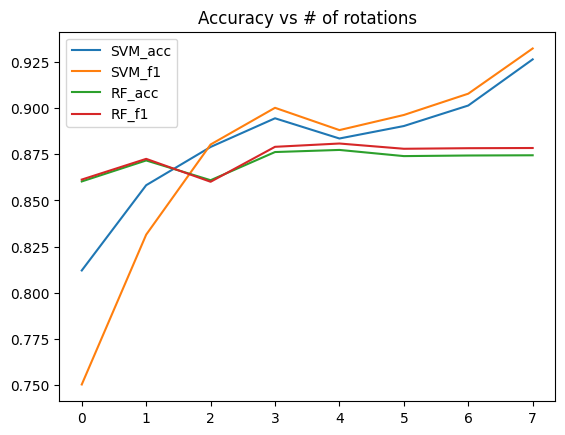

In [71]:
ax = results_all[["SVM_acc", "SVM_f1", "RF_acc", "RF_f1"]].plot(title="Accuracy vs # of rotations")

In [61]:
results_all[['SVM_acc', 'SVM_f1', 'RF_acc', 'RF_f1']].mean()

SVM_acc    0.853320
SVM_f1     0.821825
RF_acc     0.850607
RF_f1      0.846247
dtype: float64

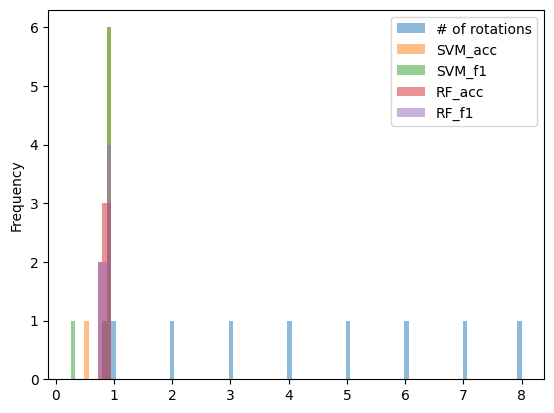

In [62]:
ax = results_all.plot.hist(bins=100, alpha=0.5)